In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n_connections = {
    "orf": {
        "similar": 200,
        "anti_similar": 200,
        },
    "crispr": {
        "similar": 200,
        "anti_similar": 200,
    }
}

similar_threshold = 0.4
anti_similar_threshold = -0.4

How many gene pairs are common between the top similar and anti-similar ORF and CRISPR genes?

In [3]:
gene_similarity_df_stacked = pd.DataFrame()

for modality, value in n_connections.items():
    for direction, n in value.items():
        df = pd.read_csv(f"output/{modality}_top_{direction}_genes.csv", index_col=0)
        df_stacked = (
            df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
            .stack()
            .reset_index()
            .rename(columns={0: "cos_sim", "level_0": "gene_1", "level_1": "gene_2"})
        )
        df_stacked = df_stacked.query("gene_1 != gene_2")
        if direction == "similar":
            top_genes_stacked = df_stacked.nlargest(n, "cos_sim")
        elif direction == "anti_similar":
            top_genes_stacked = df_stacked.nsmallest(n, "cos_sim")
        top_genes_stacked["modality"] = modality
        top_genes_stacked["direction"] = direction

        gene_similarity_df_stacked = pd.concat(
            [gene_similarity_df_stacked, top_genes_stacked], axis=0, ignore_index=True
        )

In [4]:
orf_df = (
    gene_similarity_df_stacked.query("modality == 'orf'")
    .reset_index(drop=True)
    .rename(columns={"gene_1": "gene_1_orf", "gene_2": "gene_2_orf"})
).drop(columns=["modality"])
crispr_df = (
    gene_similarity_df_stacked.query("modality == 'crispr'")
    .reset_index(drop=True)
    .rename(columns={"gene_1": "gene_1_crispr", "gene_2": "gene_2_crispr"})
).drop(columns=["modality"])

In [5]:
orf_crispr_similarity_df = pd.concat(
    [
        orf_df.merge(
            crispr_df,
            left_on=["gene_1_orf", "gene_2_orf"],
            right_on=["gene_1_crispr", "gene_2_crispr"],
            suffixes=("_orf", "_crispr"),
            how="inner",
        ),
        orf_df.merge(
            crispr_df,
            left_on=["gene_1_orf", "gene_2_orf"],
            right_on=["gene_2_crispr", "gene_1_crispr"],
            suffixes=("_orf", "_crispr"),
            how="inner",
        ),
    ],
    ignore_index=True,
)

orf_crispr_similarity_df.head()

,gene_1_orf,gene_2_orf,cos_sim_orf,direction_orf,gene_1_crispr,gene_2_crispr,cos_sim_crispr,direction_crispr


There aren't any gene pairs that are present in both the ORF and CRISPR dataframes. Below I look for such pairs by defining top similar and anti-similar gene pairs as those with a cosine similarity greater than 0.4 or less than -0.4, respectively.

In [6]:
orf_df_all = pd.read_parquet("cos_sim/cosine_similarities_genes_orf.parquet")
orf_df = (
    orf_df_all.where(np.triu(np.ones(orf_df_all.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: "cos_sim", "level_0": "gene_1_orf", "level_1": "gene_2_orf"})
    .query("gene_1_orf != gene_2_orf")
    .query("cos_sim > @similar_threshold or cos_sim < @anti_similar_threshold")
    .reset_index(drop=True)
    .assign(
        direction=lambda x: np.where(
            x["cos_sim"] > similar_threshold, "similar", "anti_similar"
        )
    )
)

orf_df.head()

,gene_1_orf,gene_2_orf,cos_sim,direction
0,CEBPG,EHMT2,0.438442,similar
1,CEBPG,PASD1,0.458652,similar
2,CEBPG,ZNF574,0.425144,similar
3,CEBPG,DNM2,0.459123,similar
4,CEBPG,SLFN11,0.475011,similar


In [7]:
crispr_df_all = pd.read_parquet("cos_sim/cosine_similarities_genes_crispr.parquet")
crispr_df = (
    crispr_df_all.where(np.triu(np.ones(crispr_df_all.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: "cos_sim", "level_0": "gene_1_crispr", "level_1": "gene_2_crispr"})
    .query("gene_1_crispr != gene_2_crispr")
    .query("cos_sim > @similar_threshold or cos_sim < @anti_similar_threshold")
    .reset_index(drop=True)
    .assign(
        direction=lambda x: np.where(
            x["cos_sim"] > similar_threshold, "similar", "anti_similar"
        )
    )
)

crispr_df.head()

,gene_1_crispr,gene_2_crispr,cos_sim,direction
0,PALS2,PDE9A,0.400876,similar
1,PALS2,ISYNA1,-0.442096,anti_similar
2,SEPTIN1,ARHGAP5,0.494561,similar
3,SEPTIN1,RAD51,0.402543,similar
4,SEPTIN1,ERP44,-0.426058,anti_similar


In [8]:
# Combine ORF and CRISPR

orf_crispr_similarity_df = pd.concat(
    [
        orf_df.merge(
            crispr_df,
            left_on=["gene_1_orf", "gene_2_orf"],
            right_on=["gene_1_crispr", "gene_2_crispr"],
            suffixes=("_orf", "_crispr"),
            how="inner",
        ),
        orf_df.merge(
            crispr_df,
            left_on=["gene_1_orf", "gene_2_orf"],
            right_on=["gene_2_crispr", "gene_1_crispr"],
            suffixes=("_orf", "_crispr"),
            how="inner",
        ),
    ],
    ignore_index=True,
)

Gene pairs where the ORF and CRISPR direction are the same

In [9]:
same_direction_df = orf_crispr_similarity_df.query("direction_orf == direction_crispr").reset_index(drop=True)
same_direction_df

,gene_1_orf,gene_2_orf,cos_sim_orf,direction_orf,gene_1_crispr,gene_2_crispr,cos_sim_crispr,direction_crispr
0,LMNA,RNF41,0.495585,similar,LMNA,RNF41,0.511542,similar
1,COQ8A,MCAT,0.529447,similar,COQ8A,MCAT,0.492001,similar
2,CHRM1,DRD2,0.569346,similar,CHRM1,DRD2,0.436542,similar
3,PIP5K1A,MATK,0.475641,similar,PIP5K1A,MATK,0.429282,similar
4,GPER1,CHRFAM7A,0.415221,similar,GPER1,CHRFAM7A,0.469301,similar
5,GPER1,GPR176,0.403062,similar,GPER1,GPR176,0.430877,similar
6,COQ8B,PGLYRP1,0.448001,similar,COQ8B,PGLYRP1,0.425157,similar
7,SLC22A6,CHRFAM7A,0.405189,similar,SLC22A6,CHRFAM7A,0.466099,similar
8,BDKRB1,OPRK1,0.444150,similar,BDKRB1,OPRK1,0.403894,similar
9,BCAT2,PGLYRP1,0.434204,similar,BCAT2,PGLYRP1,0.481217,similar


In [10]:
diff_direction_df = orf_crispr_similarity_df.query("direction_orf != direction_crispr").reset_index(drop=True)
diff_direction_df

,gene_1_orf,gene_2_orf,cos_sim_orf,direction_orf,gene_1_crispr,gene_2_crispr,cos_sim_crispr,direction_crispr
0,RAF1,DUSP6,-0.515148,anti_similar,RAF1,DUSP6,0.414990,similar
1,MAP2,PAFAH1B1,0.408635,similar,MAP2,PAFAH1B1,-0.426557,anti_similar
2,STT3A,CHRFAM7A,0.601129,similar,STT3A,CHRFAM7A,-0.491085,anti_similar
3,STT3A,GPR176,0.535408,similar,STT3A,GPR176,-0.476921,anti_similar
4,CHRM1,CHRFAM7A,0.542636,similar,CHRM1,CHRFAM7A,-0.503668,anti_similar
5,CHRM1,GPR176,0.716921,similar,CHRM1,GPR176,-0.442060,anti_similar
6,AQP12B,MBTPS2,0.464551,similar,AQP12B,MBTPS2,-0.417633,anti_similar
7,CYP11B1,CSNK1E,0.405962,similar,CYP11B1,CSNK1E,-0.421797,anti_similar
8,STK40,JUN,0.434611,similar,STK40,JUN,-0.403963,anti_similar
9,BCAT2,SDHB,0.763874,similar,BCAT2,SDHB,-0.414936,anti_similar


In [11]:
same_direction_genes = list(
    np.unique([same_direction_df.gene_1_orf, same_direction_df.gene_2_orf])
)

diff_direction_genes = list(
    np.unique([diff_direction_df.gene_1_orf, diff_direction_df.gene_2_orf])
)

orf_same_direction_df = orf_df_all.loc[same_direction_genes, same_direction_genes]
crispr_same_direction_df = crispr_df_all.loc[same_direction_genes, same_direction_genes]
orf_diff_direction_df = orf_df_all.loc[diff_direction_genes, diff_direction_genes]
crispr_diff_direction_df = crispr_df_all.loc[diff_direction_genes, diff_direction_genes]

In [12]:
same_direction_matrix = np.triu(orf_same_direction_df)
same_direction_matrix += np.tril(crispr_same_direction_df)
np.fill_diagonal(same_direction_matrix, 0)

same_direction_matrix_df = pd.DataFrame(
    same_direction_matrix, index=same_direction_genes, columns=same_direction_genes
)

different_direction_matrix = np.triu(orf_diff_direction_df)
different_direction_matrix += np.tril(crispr_diff_direction_df)
np.fill_diagonal(different_direction_matrix, 0)

different_direction_matrix_df = pd.DataFrame(
    different_direction_matrix, index=diff_direction_genes, columns=diff_direction_genes
)

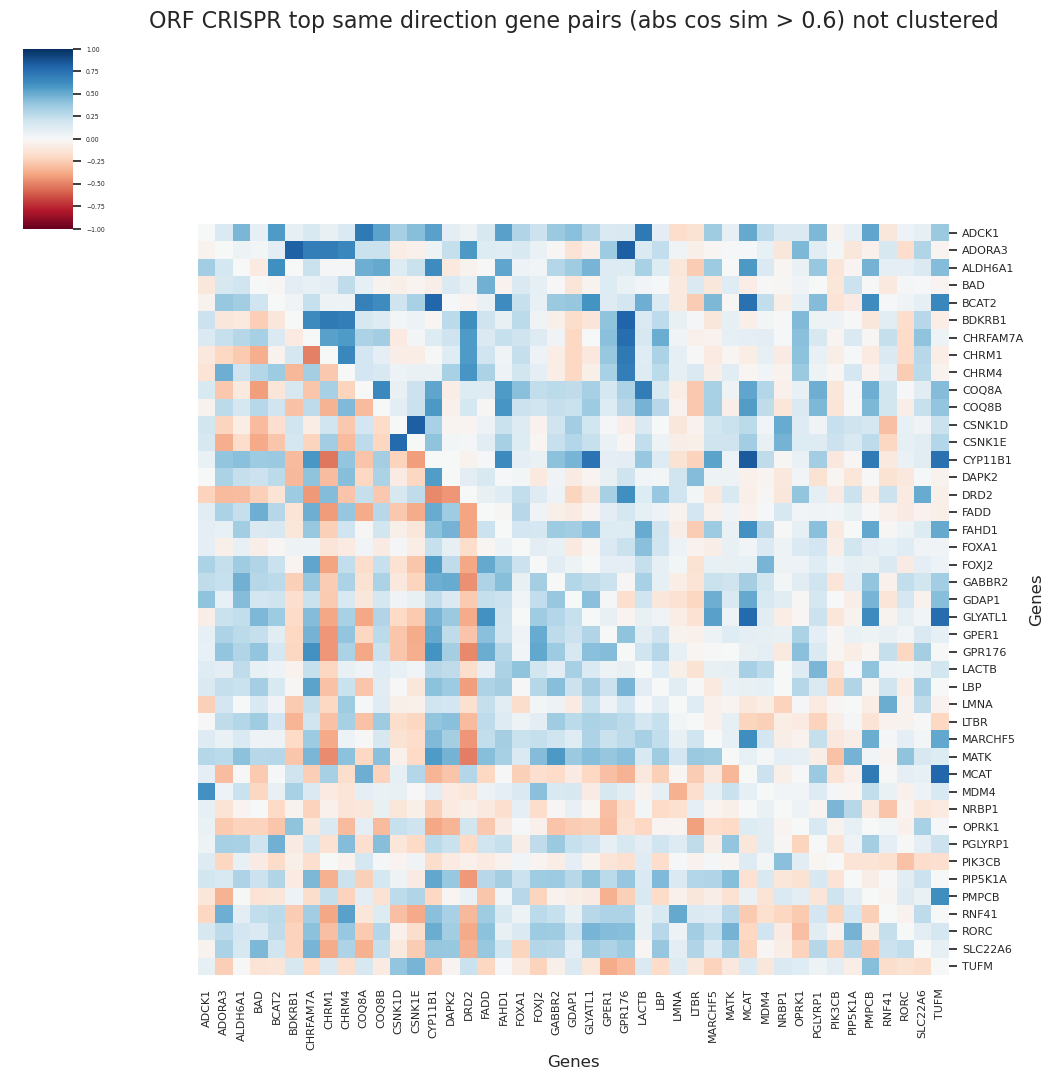

In [13]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    same_direction_matrix_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    col_cluster=False,
    row_cluster=False,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=8)
f.ax_heatmap.yaxis.set_tick_params(labelsize=8)
f.ax_heatmap.set_title(
    "ORF CRISPR top same direction gene pairs (abs cos sim > 0.6) not clustered", fontsize=16, y=1.25
)
f.savefig("figures/orf_crispr_top_same_direction_genes.png")
f.savefig("figures/orf_crispr_top_same_direction_genes.svg")

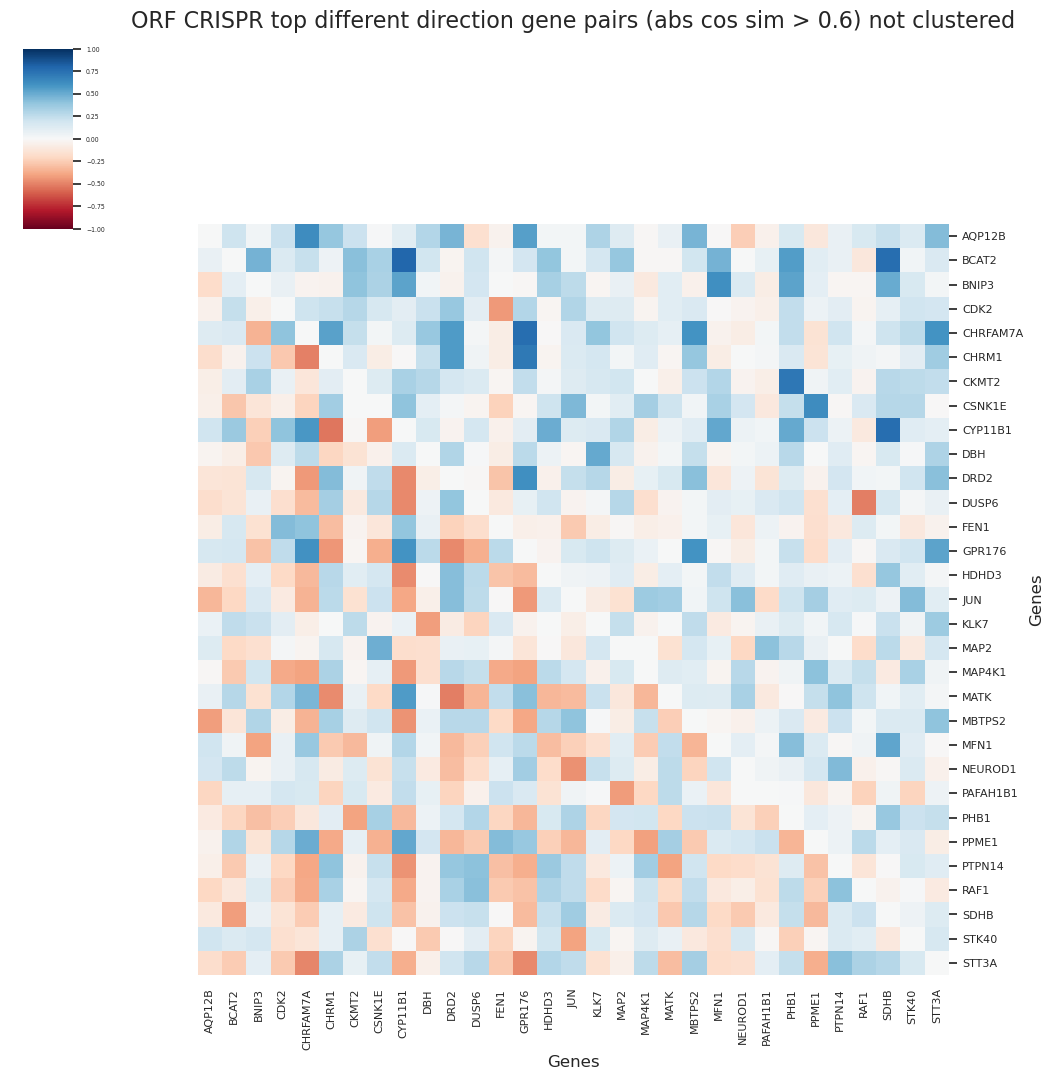

In [14]:
sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    different_direction_matrix_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    col_cluster=False,
    row_cluster=False,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=8)
f.ax_heatmap.yaxis.set_tick_params(labelsize=8)
f.ax_heatmap.set_title(
    "ORF CRISPR top different direction gene pairs (abs cos sim > 0.6) not clustered",
    fontsize=16,
    y=1.25,
)
f.savefig("figures/orf_crispr_top_different_direction_genes.png")
f.savefig("figures/orf_crispr_top_different_direction_genes.svg")